In [1]:
## import potřebných knihoven
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import tree
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('crime_stations_transformed2.csv', sep = ',', header = 0)

crimes = pd.DataFrame(data)

In [3]:
crimes['Age_Category'] = crimes['Age_Category'].fillna('0-18') ## doplnění chybějících hodnot, které nebyly při transformaci ošetřeny

## výběr jen některých atributů
crimes = crimes[['Month','Daytime','Race','Age_Category','Gender','Weapon','PremiseType','Old_District','distance_to_police','Police_in_neigh','Description','Neighborhood']]

In [4]:
## implementace rozhodovacího stromu v knihovně sci-kit learn umí pracovat pouze s numerickými atributy a je potřeba tak zavést One Hot Encoding pro kategoriální atributy
encoder = OneHotEncoder(sparse_output=False, handle_unknown='error')

In [5]:
## výběr atributů pro práci
to_encode = crimes[['Daytime','PremiseType','Weapon','Gender','Month','Race','Age_Category','Police_in_neigh','Old_District']]


In [6]:
## zakódování atributů do formátu One Hot Encoding
encoded = encoder.fit_transform(to_encode) 

In [7]:
## vytvoříme si názvy sloupců
encoded_column_names = [f'{col}_{cat}' for i, col in enumerate(to_encode.columns) for cat in encoder.categories_[i]]

In [8]:
## sjednotíme si zakódované a původní data
encoded_df = pd.DataFrame(encoded, columns=encoded_column_names)
crimes[encoded_column_names] = encoded_df.copy()

/tmp/ipykernel_735/3018157026.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  crimes[encoded_column_names] = encoded_df.copy()
/tmp/ipykernel_735/3018157026.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  crimes[encoded_column_names] = encoded_df.copy()
/tmp/ipykernel_735/3018157026.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmen

In [9]:
## cílová proměnná je description
y = crimes.Description

# prediktory
x = crimes[encoded_column_names]


In [10]:
## rozdělení datasetu na trénovací a testovací část
train_x, test_x,train_y,test_y = train_test_split(x,y,stratify = y,test_size=0.20)


In [17]:
## použit rozhodovací strom
tree1 = DecisionTreeClassifier(criterion = 'gini', max_depth=3, min_samples_leaf=20, min_samples_split=20)

tree1 = tree1.fit(train_x, train_y)



In [18]:
## správnost klasifikace rozhodovacího stromu
scores = tree1.score(test_x, test_y)
scores

0.4656474626296459

In [19]:
import pandas as pd
predicted = pd.DataFrame(tree1.predict(test_x))
joined_df = pd.concat([test_y.reset_index(drop=True), predicted], axis=1)
joined_df.columns = ['Description', 'Predicted']
joined_df = pd.DataFrame(joined_df)
joined_df


,Description,Predicted
0,LARCENY FROM AUTO,LARCENY FROM AUTO
1,LARCENY FROM AUTO,LARCENY
2,LARCENY FROM AUTO,LARCENY FROM AUTO
3,BURGLARY,BURGLARY
4,BURGLARY,LARCENY FROM AUTO
...,...,...
120612,AGG. ASSAULT,AGG. ASSAULT
120613,LARCENY FROM AUTO,BURGLARY
120614,BURGLARY,LARCENY
120615,LARCENY,LARCENY


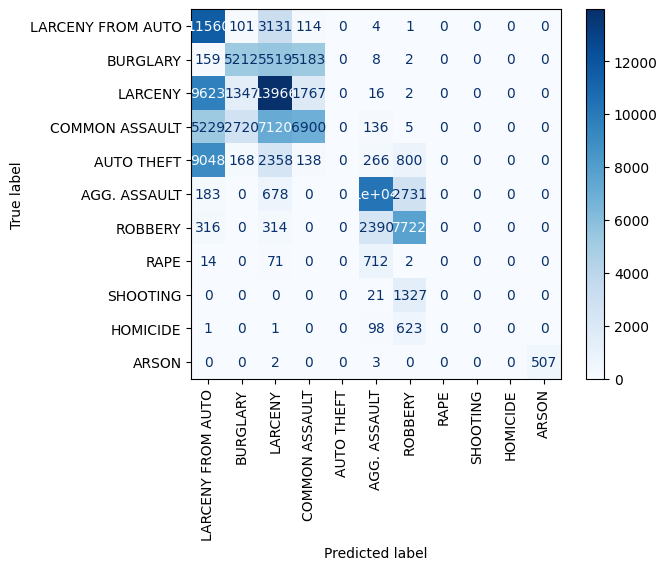

In [21]:
## zobrazení confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(test_y, predicted,labels = list(test_y.unique()))
cmtx = pd.DataFrame(
    confusion_matrix(test_y, predicted, labels=list(test_y.unique())), 
    index=['{:}'.format(x) for x in list(test_y.unique())], 
    columns=['{:}'.format(x) for x in list(test_y.unique())])


cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cmtx.index, )
cm_display.plot(cmap='Blues')
plt.xticks(rotation = 'vertical')
plt.show()


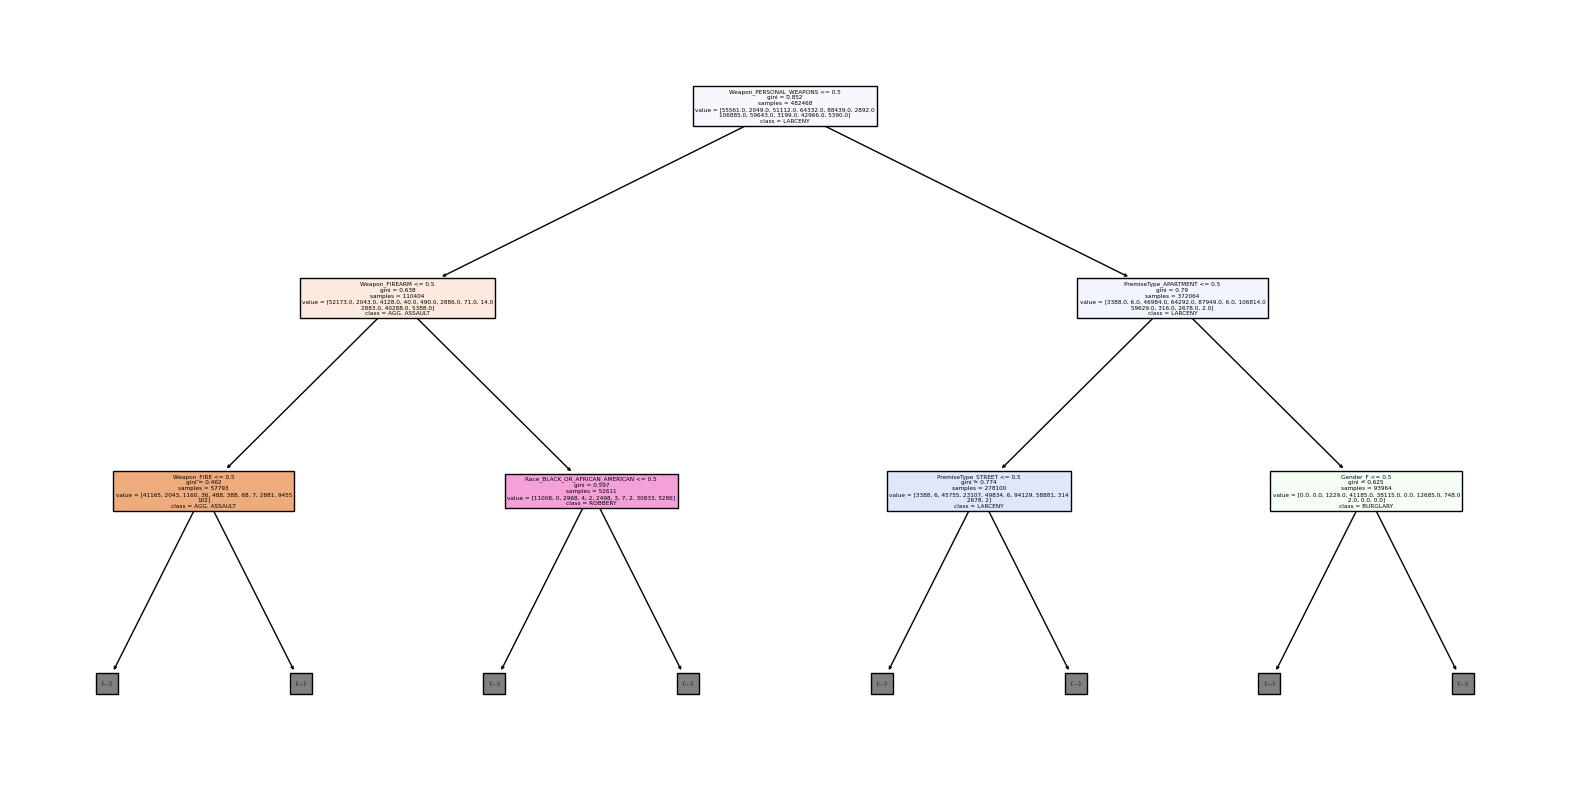

In [22]:
## vykreslení části stromu
plt.figure(figsize=(20,10))
tree.plot_tree(tree1, filled=True, feature_names=encoded_column_names, class_names=tree1.classes_, max_depth=2)
plt.show()


In [24]:
## část stromu jako text
from sklearn.tree import export_text
tree_rules = export_text(tree1, feature_names=list(train_x.columns))
print(tree_rules)

|--- Weapon_PERSONAL_WEAPONS <= 0.50
|   |--- Weapon_FIREARM <= 0.50
|   |   |--- Weapon_FIRE <= 0.50
|   |   |   |--- class: AGG. ASSAULT
|   |   |--- Weapon_FIRE >  0.50
|   |   |   |--- class: ARSON
|   |--- Weapon_FIREARM >  0.50
|   |   |--- Race_BLACK_OR_AFRICAN_AMERICAN <= 0.50
|   |   |   |--- class: ROBBERY
|   |   |--- Race_BLACK_OR_AFRICAN_AMERICAN >  0.50
|   |   |   |--- class: ROBBERY
|--- Weapon_PERSONAL_WEAPONS >  0.50
|   |--- PremiseType_APARTMENT <= 0.50
|   |   |--- PremiseType_STREET <= 0.50
|   |   |   |--- class: LARCENY
|   |   |--- PremiseType_STREET >  0.50
|   |   |   |--- class: LARCENY FROM AUTO
|   |--- PremiseType_APARTMENT >  0.50
|   |   |--- Gender_F <= 0.50
|   |   |   |--- class: BURGLARY
|   |   |--- Gender_F >  0.50
|   |   |   |--- class: COMMON ASSAULT

